### Visualization
We will visualize the results after training in this notebook. 
- Plain sampling oversamples empty spaces in the western united states, so we cherrypick some good samples
- The results are very finicky if we pick any sample and try embedding manipulations; So, we try to cherry pick some good examples.
- This need should go away once we have a decent trainned example
- all these indices are for level14 zoom and tiles generated using url generator. If that file changes, all these will become garbage.

### Common Setup

In [1]:
%load_ext autoreload
%autoreload 2

In [46]:
%matplotlib inline

from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import seaborn as sns
sns.set_style("darkgrid")
from PIL import Image
from torchvision import transforms
import torch

import torchvision
from torch.utils.data.sampler import WeightedRandomSampler
from tensorboardX import SummaryWriter
import seaborn as sns
sns.set_style("darkgrid")

In [3]:
from networks import Loc2Vec
from datasets import GeoTileInferDataset, get_files_from_path, cleanse_files
from config import IMG_SIZE
# from map_network import Geo2Vec
# from map_datasets import GeoTileInferDataset, IMG_SIZE, get_files_from_path, cleanse_files

In [4]:
cuda = torch.cuda.is_available()

In [5]:
checkpoint_file = './checkpoint_0.pth'

In [7]:
model = Loc2Vec()
model = torch.load(checkpoint_file)
model.eval()
if cuda:
    model.cuda()

In [8]:
infer_transforms = transforms.Compose([
    transforms.CenterCrop(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])])
bs = 56
dset_eval = GeoTileInferDataset("./../tile/14",
                                center_transform=infer_transforms)
pd_files = dset_eval.get_file_df()
weights = pd_files.frequency
infer_sampler = WeightedRandomSampler(weights, len(dset_eval))
# Should numworkers be 1?
kwargs = {'num_workers': 8, 'pin_memory': True} if cuda else {}
online_eval_loader = torch.utils.data.DataLoader(dset_eval, batch_size=bs,
                                                 sampler=infer_sampler, **kwargs)

753088


### Get all embedding and store
we shall use the annoy library store all the vectors and built a tree based on the euclidean distance for fast retrival

In [9]:
from annoy import AnnoyIndex
t = AnnoyIndex(16, metric='euclidean')  # Length of item vector that will be indexed

In [10]:
with torch.no_grad():
    model.eval()
    val_loss = 0
    for batch_idx, (data, target) in enumerate(online_eval_loader):
        if cuda:
            data = data.cuda()
        outputs = model(data)
        for i in range(0, len(target)):
            t.add_item(target[i], outputs[i])
        if batch_idx % 1000 == 0:
            print("Processed :", batch_idx, " items")

Processed : 0  items
Processed : 1000  items
Processed : 2000  items
Processed : 3000  items
Processed : 4000  items
Processed : 5000  items
Processed : 6000  items
Processed : 7000  items
Processed : 8000  items
Processed : 9000  items
Processed : 10000  items
Processed : 11000  items
Processed : 12000  items
Processed : 13000  items


In [11]:
t.build(25)
t.save('embeddings.ann')

True

In [12]:
t.load('embeddings.ann')

True

In [13]:
pd_files =  dset_eval.get_file_df()

### Sample of tiles

Cherry picked indices are used in the indices and plotted. We will cross reference this when trying to see other results like interpolation and nearest neighbors.

If we don't do this, the sampling would largely sample uninteresting areas!

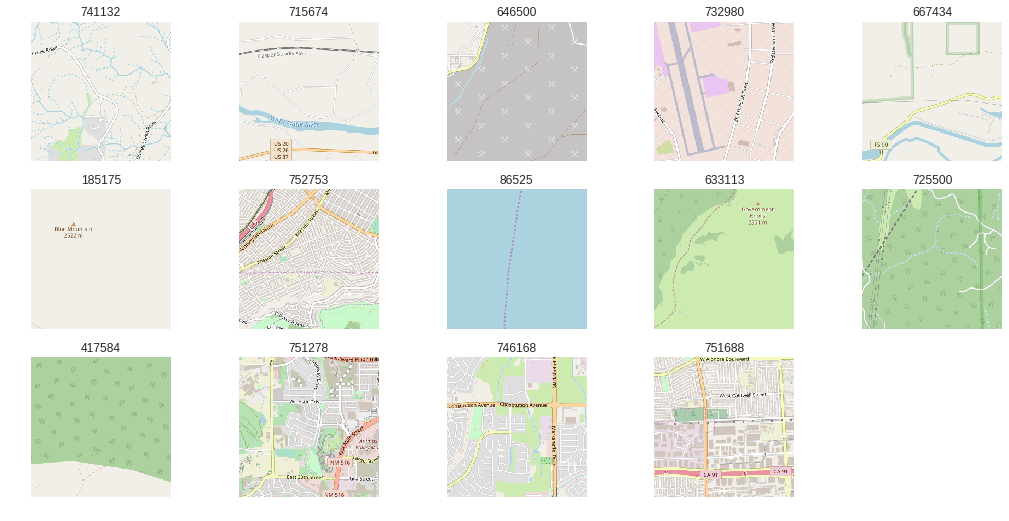

In [41]:
indices = [741132, 715674, 646500, 732980, 667434,
           185175, 752753, 86525, 633113, 725500, 417584, 751278, 746168, 751688]
columns = 5
rows = 6

w = 15
h = 15
fig = plt.figure(figsize=(18, 18))

for i, index in enumerate(indices):
    img = np.random.randint(10, size=(h, w))
    fig.add_subplot(rows, columns, i+1)
    img = Image.open(pd_files.path[index], 'r')
    data = img.convert('RGB')
    t_img = torch.from_numpy(np.asarray(data))
    t_img_np = t_img.numpy()
    plt.axis('off')
    plt.title(index)
    plt.imshow(t_img_np)

plt.show()

### Find nearest neighbors

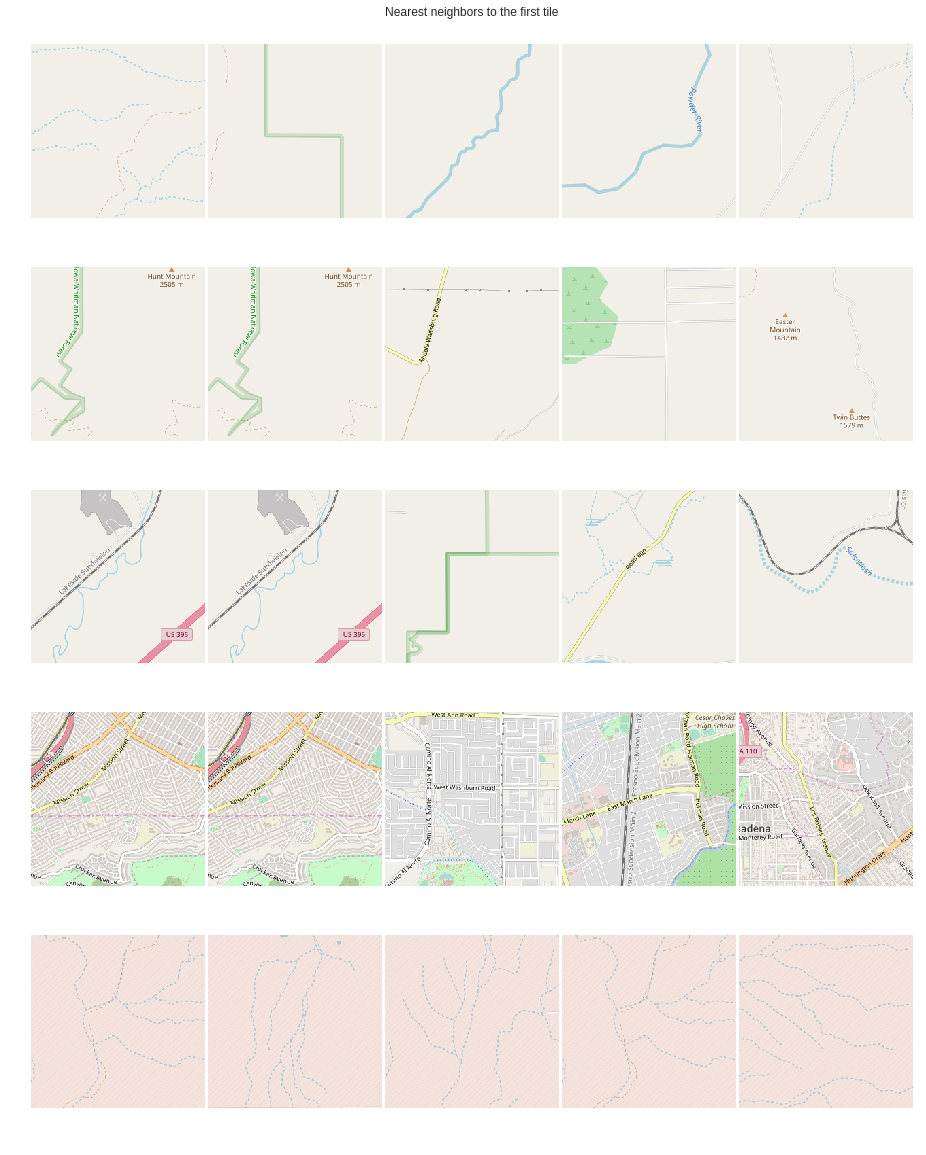

In [59]:
def get_sample_nn(row, column):
    samples = pd_files.sample(row)
    result = []
    for i in samples.index.values:
        result = result + [i]
        result = result + t.get_nns_by_item(i, column-1)
    return result


def get_nn(indices, column):
    result = []
    for i in indices:
        result = result + [i]
        result = result + t.get_nns_by_item(i, column-1)
    return result


columns = 5
rows = 5
# We run get_sample_nn multiple times to get interesting looking indices
# There are a lot of empty spaces, which would not provide good results
# due to data sampling; hence we cherry pick a few by uncommenting and 
# running the below; 
# results = get_sample_nn(rows, columns)
input_indices = [534212, 619328, 679405, 752753, 604364]
results = get_nn(input_indices[:rows], columns)

w = 15
h = 15
fig = plt.figure(figsize=(18, 22))

plt.subplots_adjust(left=0.32, bottom=0, right=1.0, top=0.7, wspace=0.02, hspace=0.02)
plt.title("Nearest neighbors to the first tile")
plt.axis('off')
for i, index in enumerate(results):
    img = np.random.randint(10, size=(h, w))
    fig.add_subplot(rows, columns, i+1)
    img = Image.open(pd_files.path[index], 'r')
    data = img.convert('RGB')
    t_img = torch.from_numpy(np.asarray(data))
    t_img_np = t_img.numpy()
#     plt.title(index)
    plt.axis('off')
    plt.imshow(t_img_np)

plt.show()

### Interpolation between two embeddings
If the embeddings are good, there should be smooth interpolation between two different types of locations.

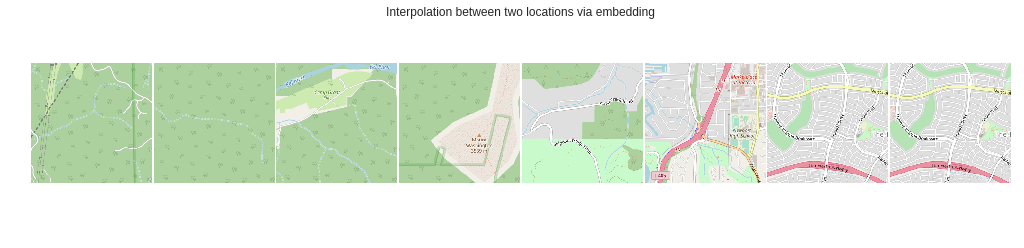

In [54]:
interpolation_size = 6
# interpolate from 185175 to 751688
from scipy.interpolate import interp1d
# These numbers are cherry picked. Once we train for longer, we can remove it
begin_index = 725500
end_index = 750068
fst = t.get_item_vector(begin_index)
snd = t.get_item_vector(end_index)
linfit = interp1d([1,interpolation_size], np.vstack([fst, snd]), axis=0)

item = []
item = item + [begin_index]
for i in range(0,interpolation_size):    
    item = item + t.get_nns_by_vector(linfit(i+1),1)

item = item + [end_index]
columns = 8
rows = 1


w=15
h=15
fig=plt.figure(figsize=(20,4))
plt.title("Interpolation between two locations via embedding")
plt.subplots_adjust(left=0.32, bottom=0, right=1.0, top=0.7, wspace=0.02, hspace=0.02)
plt.axis('off')
for i, index in enumerate(item):
    img = np.random.randint(10, size=(h,w))
    fig.add_subplot(rows, columns, i+1)
    img = Image.open(pd_files.path[index], 'r')
    data = img.convert('RGB')        
    t_img = torch.from_numpy(np.asarray(data))
    t_img_np = t_img.numpy()
#     plt.title(index)
    plt.axis('off')
    plt.imshow(t_img_np)
    
plt.show()

### PCA and TSNE plots


In [17]:
!rm -rf tensorboard/

In [18]:
writer = SummaryWriter('tensorboard')
# https://discuss.pytorch.org/t/simple-way-to-inverse-transform-normalization/4821/7
inv_normalize = transforms.Normalize(
    mean=[-0.485 * 0.229, -0.456 * 0.224, -0.406 * 0.255],
    std=[1/0.229, 1/0.224, 1/0.255]
)

all_outputs = None
all_targets = None
all_data = None
with torch.no_grad():
    model.eval()
    val_loss = 0
    for batch_idx, (data, target) in enumerate(online_eval_loader):
        if cuda:
            data = data.cuda()
        outputs = model(data)
#         outputs = outputs.data.cpu().numpy()
        if all_outputs is None:
#             print("in here")
            all_outputs = outputs.clone()
            all_targets = target.clone()
            all_data = data.clone()
        else:
#             print("nin here")
            all_outputs = torch.cat([outputs, all_outputs], 0)
            all_targets = torch.cat([target, all_targets], 0)
            all_data = torch.cat([data, all_data], 0)

        if batch_idx == 70:
            all_data = torch.stack([inv_normalize(data) for data in all_data],0)
            print(all_outputs.shape, all_targets.shape, all_data.shape)
            writer.add_embedding(all_outputs, metadata=all_targets, label_img=all_data)
            all_data = None
            all_outputs = None
            all_targets = None
            torch.cuda.empty_cache()
            break

torch.Size([3976, 16]) torch.Size([3976]) torch.Size([3976, 3, 128, 128])


If you run the following in the commandline, you should see PCA and TSNE Plots. Checking the 'spherical coordinates' box makes the plot look better.

`tensorboard --logdir tensorboard`
#### PCA 
![Interpolation](images/pca.png)
#### TSNE
![TSNE](images/tsne.png)